<a href="https://colab.research.google.com/github/pdomins/bayesian-learning/blob/master/ej1_bayes_brits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("data/2-PreferenciasBritanicos(TP1).xlsx")
df

,scones,cerveza,wiskey,avena,futbol,Nacionalidad
0,0,0,1,1,1,I
1,1,0,1,1,0,I
2,1,1,0,0,1,I
3,1,1,0,0,0,I
4,0,1,0,0,1,I
5,0,0,0,1,0,I
6,1,0,0,1,1,E
7,1,1,0,0,1,E
8,1,1,1,1,0,E
9,1,1,0,1,0,E


### Generic Naive Bayes

In [3]:
def calculate_conditional_probs(df, attributes, out_label, laplace_smoothing=False):
    conditional_probs = {}
    for attribute in attributes:
        conditional_probs[attribute] = {}
        for characteristic in df[out_label].unique():
            data_by_out_label = df[df[out_label] == characteristic]
            if laplace_smoothing:
                attr_count_by_characteristic = data_by_out_label[attribute].value_counts()
                k = len(df[attribute].unique())
                total_samples = len(data_by_out_label)
                for value in df[attribute].unique():
                    conditional_probs[attribute][(value, characteristic)] = (attr_count_by_characteristic.get(value, 0) + 1) / (total_samples + k)
            else:
                for value in df[attribute].unique():
                    attr_count_by_characteristic = data_by_out_label[attribute].value_counts(normalize=True)
                    conditional_probs[attribute][(value, characteristic)] = attr_count_by_characteristic.get(value, 0)

    return conditional_probs

def get_probabilities_multiplication(df, attributes, out_label, out_label_probs, output_df, conditional_probs):
    probabilities = {}
    for example_index, example_values in output_df.iterrows():
        prob_dict = {}
        for characteristic in df[out_label].unique():
            prob = out_label_probs[characteristic]
            for attribute in example_values.index:
                value = example_values[attribute]
                prob *= conditional_probs[attribute][(value, characteristic)]
            prob_dict[characteristic] = prob
        prob_dict['max'] = max(prob_dict, key=prob_dict.get)
        probabilities[example_index] = prob_dict

    return probabilities

def get_prediction(df, output_df, laplace_smoothing=False):
    attributes = df.columns.tolist()
    out_label = attributes.pop()
    out_label_probs = df[out_label].value_counts(normalize=True)
    conditional_probs = calculate_conditional_probs(df, attributes, out_label, laplace_smoothing)
    return get_probabilities_multiplication(df, attributes, out_label, out_label_probs, output_df, conditional_probs)

In [4]:
data = {
    "scones":   [1, 0],
    "cerveza":  [0, 1],
    "wiskey":   [1, 1],
    "avena":    [1, 0],
    "futbol":   [0, 1]
}

output_df = pd.DataFrame(data)

predictions = get_prediction(df, output_df, laplace_smoothing=True)

for example_index, example_values in predictions.items():
    print("Example {}: Predicted Nationality: {}".format(example_index, example_values.get('max')))

Example 0: Predicted Nationality: E
Example 1: Predicted Nationality: I


# Predicting 'Nationality' of the whole dataset
(Using the same data for train and test)

In [5]:
predictions = get_prediction(df, df.iloc[:, :-1], laplace_smoothing=True)
df_copy = df.copy()
for example_index, example_values in predictions.items():
    df_copy.loc[example_index, 'P-Nacionalidad'] = example_values.get('max')
df_copy

,scones,cerveza,wiskey,avena,futbol,Nacionalidad,P-Nacionalidad
0,0,0,1,1,1,I,I
1,1,0,1,1,0,I,E
2,1,1,0,0,1,I,E
3,1,1,0,0,0,I,E
4,0,1,0,0,1,I,I
5,0,0,0,1,0,I,I
6,1,0,0,1,1,E,E
7,1,1,0,0,1,E,E
8,1,1,1,1,0,E,E
9,1,1,0,1,0,E,E


### Naive Bayes

In [6]:
nationality_probs = df["Nacionalidad"].value_counts(normalize=True)
tastes = ["scones", "cerveza", "wiskey", "avena", "futbol"]

In [7]:
#NO LAPLACE SMOOTHING
conditional_probs = {}

for taste in tastes:
  conditional_probs[taste] = {}
  for nationality in df["Nacionalidad"].unique():
    data_by_nationality = df[df["Nacionalidad"] == nationality]
    tastes_amount_by_nationality = data_by_nationality[taste].value_counts(normalize=True)

    for value in df[taste].unique():
      conditional_probs[taste][(value, nationality)] = tastes_amount_by_nationality.get(value, 0)

conditional_probs

{'scones': {(0, 'I'): 0.5, (1, 'I'): 0.5, (0, 'E'): 0, (1, 'E'): 1.0},
 'cerveza': {(0, 'I'): 0.5,
  (1, 'I'): 0.5,
  (0, 'E'): 0.42857142857142855,
  (1, 'E'): 0.5714285714285714},
 'wiskey': {(1, 'I'): 0.3333333333333333,
  (0, 'I'): 0.6666666666666666,
  (1, 'E'): 0.42857142857142855,
  (0, 'E'): 0.5714285714285714},
 'avena': {(1, 'I'): 0.5,
  (0, 'I'): 0.5,
  (1, 'E'): 0.7142857142857143,
  (0, 'E'): 0.2857142857142857},
 'futbol': {(1, 'I'): 0.5,
  (0, 'I'): 0.5,
  (1, 'E'): 0.42857142857142855,
  (0, 'E'): 0.5714285714285714}}

In [8]:
# LAPLACE SMOOTHING
laplace_conditional_probs = {}

for taste in tastes:
  laplace_conditional_probs[taste] = {}
  for nationality in df["Nacionalidad"].unique():
    data_by_nationality = df[df["Nacionalidad"] == nationality]
    tastes_amount_by_nationality = data_by_nationality[taste].value_counts()
    total_samples = len(data_by_nationality[taste])
    k = len(df[taste].unique())

    for value in df[taste].unique():
      laplace_conditional_probs[taste][(value, nationality)] = (tastes_amount_by_nationality.get(value, 0) + 1) / (total_samples + k)

laplace_conditional_probs

{'scones': {(0, 'I'): 0.5,
  (1, 'I'): 0.5,
  (0, 'E'): 0.1111111111111111,
  (1, 'E'): 0.8888888888888888},
 'cerveza': {(0, 'I'): 0.5,
  (1, 'I'): 0.5,
  (0, 'E'): 0.4444444444444444,
  (1, 'E'): 0.5555555555555556},
 'wiskey': {(1, 'I'): 0.375,
  (0, 'I'): 0.625,
  (1, 'E'): 0.4444444444444444,
  (0, 'E'): 0.5555555555555556},
 'avena': {(1, 'I'): 0.5,
  (0, 'I'): 0.5,
  (1, 'E'): 0.6666666666666666,
  (0, 'E'): 0.3333333333333333},
 'futbol': {(1, 'I'): 0.5,
  (0, 'I'): 0.5,
  (1, 'E'): 0.4444444444444444,
  (0, 'E'): 0.5555555555555556}}

In [9]:
example1 = {
    "scones": 1,
    "cerveza":0,
    "wiskey":1,
    "avena":1,
    "futbol":0
}
example2 = {
    "scones": 0,
    "cerveza": 1,
    "wiskey": 1,
    "avena": 0,
    "futbol": 1
}

for ex in [example1, example2]:
  probabilities = {}
  for nationality in df["Nacionalidad"].unique():
      prob = nationality_probs[nationality]
      for taste in tastes:
        value = ex.get(taste)
        # change laplace_conditional_probs to conditional_probs in order to get the probabilities without laplace smoothing
        prob *= laplace_conditional_probs[taste][(value, nationality)]
      probabilities[nationality] = prob

  print(probabilities)
  total_probs = sum(probabilities.values())
  for key, value in probabilities.items():
    print(f"{key} {value/total_probs}")
  print("Predicted Nationality:", max(probabilities, key=probabilities.get))

{'I': 0.010817307692307692, 'E': 0.03501655079158508}
I 0.2360112818367491
E 0.7639887181632509
Predicted Nationality: E
{'I': 0.010817307692307692, 'E': 0.0021885344244740672}
I 0.8317268190077328
E 0.1682731809922671
Predicted Nationality: I


### Classification Error

In [10]:
# @title
def get_single_prediction(output_df : pd.Series, train_df, laplace_smoothing=False):
    return get_prediction(train_df, output_df.to_frame().T, laplace_smoothing)

In [11]:
# @title
def get_single_prediction_label(output_df : pd.Series, train_df, laplace_smoothing=False):
    return list(get_single_prediction(output_df, train_df, laplace_smoothing).values())[0]["max"]

In [12]:
# @title
from error_functions import compute_classification_error
from df_utils        import get_column_value_dict

In [13]:
# @title
train_df = df[["scones", "cerveza", "wiskey", "avena", "futbol", "Nacionalidad"]]
train_df

,scones,cerveza,wiskey,avena,futbol,Nacionalidad
0,0,0,1,1,1,I
1,1,0,1,1,0,I
2,1,1,0,0,1,I
3,1,1,0,0,0,I
4,0,1,0,0,1,I
5,0,0,0,1,0,I
6,1,0,0,1,1,E
7,1,1,0,0,1,E
8,1,1,1,1,0,E
9,1,1,0,1,0,E


In [14]:
# @title
train_df_label_dict = get_column_value_dict(df, "Nacionalidad")

In [15]:
# @title
compute_classification_error(train_df.drop("Nacionalidad", axis="columns"), train_df_label_dict, lambda s, m : get_single_prediction_label(s, m), train_df)

3

### Cross Validation

In [16]:
def train(train_df : pd.DataFrame, possible_out_labels):
    return train_df

In [17]:
# @title
from error_functions import k_fold_cross_validation

In [18]:
# @title
k_splits = k_fold_cross_validation(df, df["Nacionalidad"].unique(), "Nacionalidad", train, lambda s, m : get_single_prediction_label(s, m), 3)

In [19]:
# @title
i = 1
for k_split in k_splits:
    print("Split #{}".format(i))
    train = k_split["train"]
    test  = k_split["test"]
    display(train["df"])
    print("Train error:", train["err"])
    display(test["df"])
    print("Test error:", test["err"])
    print("\n------------------------------------------------\n")
    i += 1

Split #1


,scones,cerveza,wiskey,avena,futbol,Nacionalidad
3,1,1,0,0,0,I
10,1,1,0,1,1,E
9,1,1,0,1,0,E
8,1,1,1,1,0,E
2,1,1,0,0,1,I
5,0,0,0,1,0,I
6,1,0,0,1,1,E
0,0,0,1,1,1,I


Train error: 0


,scones,cerveza,wiskey,avena,futbol,Nacionalidad
4,0,1,0,0,1,I
12,1,0,1,0,0,E
1,1,0,1,1,0,I
11,1,0,1,1,0,E
7,1,1,0,0,1,E


Test error: 3

------------------------------------------------

Split #2


,scones,cerveza,wiskey,avena,futbol,Nacionalidad
4,0,1,0,0,1,I
12,1,0,1,0,0,E
1,1,0,1,1,0,I
11,1,0,1,1,0,E
7,1,1,0,0,1,E
2,1,1,0,0,1,I
5,0,0,0,1,0,I
6,1,0,0,1,1,E
0,0,0,1,1,1,I


Train error: 2


,scones,cerveza,wiskey,avena,futbol,Nacionalidad
3,1,1,0,0,0,I
10,1,1,0,1,1,E
9,1,1,0,1,0,E
8,1,1,1,1,0,E


Test error: 2

------------------------------------------------

Split #3


,scones,cerveza,wiskey,avena,futbol,Nacionalidad
4,0,1,0,0,1,I
12,1,0,1,0,0,E
1,1,0,1,1,0,I
11,1,0,1,1,0,E
7,1,1,0,0,1,E
3,1,1,0,0,0,I
10,1,1,0,1,1,E
9,1,1,0,1,0,E
8,1,1,1,1,0,E


Train error: 2


,scones,cerveza,wiskey,avena,futbol,Nacionalidad
2,1,1,0,0,1,I
5,0,0,0,1,0,I
6,1,0,0,1,1,E
0,0,0,1,1,1,I


Test error: 1

------------------------------------------------



In [20]:
def get_single_prediction_dict(output_df : pd.Series, train_df, laplace_smoothing=False):
    prediction = get_single_prediction(output_df, train_df, laplace_smoothing)
    prediction = prediction[list(prediction.keys())[0]]
    prediction.pop('max')
    return {
        "P" : prediction["I"],
        "N" : prediction["E"]
    }

In [21]:
pred_dict = get_single_prediction_dict(train_df.drop("Nacionalidad", axis="columns").iloc[1], train_df)

In [22]:
from confusion_matrix import calculate_confusion_matrix, \
                             calculate_roc_confusion_matrices, \
                             calculate_roc_positive_rates
import numpy as np

In [23]:
prediction_probabilities = dict()
predicted = dict()
for sample_idx, sample in train_df.drop("Nacionalidad", axis="columns").iterrows():
    predicted[sample_idx]                = get_single_prediction_label(sample, train_df)
    prediction_probabilities[sample_idx] = get_single_prediction_dict(sample, train_df)
prediction_probabilities

{0: {'P': 0.009615384615384616, 'N': 0.0},
 1: {'P': 0.009615384615384616, 'N': 0.04036779546983628},
 2: {'P': 0.019230769230769232, 'N': 0.02152949091724601},
 3: {'P': 0.019230769230769232, 'N': 0.028705987889661347},
 4: {'P': 0.019230769230769232, 'N': 0.0},
 5: {'P': 0.019230769230769232, 'N': 0.0},
 6: {'P': 0.019230769230769232, 'N': 0.04036779546983627},
 7: {'P': 0.019230769230769232, 'N': 0.02152949091724601},
 8: {'P': 0.009615384615384616, 'N': 0.053823727293115034},
 9: {'P': 0.019230769230769232, 'N': 0.07176496972415337},
 10: {'P': 0.019230769230769232, 'N': 0.05382372729311503},
 11: {'P': 0.009615384615384616, 'N': 0.04036779546983628},
 12: {'P': 0.009615384615384616, 'N': 0.01614711818793451}}

In [24]:
calculate_confusion_matrix(np.array(["I", "E"]), predicted, train_df_label_dict)

,I,E
I,3.0,3.0
E,0.0,7.0


In [25]:
train_df_label_dict_p_or_f = dict()
for key in train_df_label_dict.keys():
    train_df_label_dict_p_or_f[key] = "P" if train_df_label_dict[key] == "I" \
                                 else "N"

In [26]:
roc_conf_mats = calculate_roc_confusion_matrices(prediction_probabilities, train_df_label_dict_p_or_f, np.arange(0, 1, 0.0001))
roc_conf_mats

[{'threshold': 0.0,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.0001,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.0002,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.00030000000000000003,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.0004,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.0005,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.0006000000000000001,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.0007,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.0008,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.0009000000000000001,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 {'threshold': 0.001,
  'confusion_matrix':      P    N
  P  6.0  0.0
  N  7.0  0.0},
 

In [27]:
roc_positive_rates = calculate_roc_positive_rates(roc_conf_mats)
roc_positive_rates

[{'threshold': 0.0, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0001, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0002, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.00030000000000000003, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0004, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0005, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0006000000000000001, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0007, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0008, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0009000000000000001, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.001, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0011, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0012000000000000001, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0013000000000000002, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0014, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0015, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0016, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0017000000000000001, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0018000000000000002, 'TPR': 1.0,

In [28]:
from plotter import plot_roc_from_positive_rates, plot_multiple_roc_fromm_positive_rates

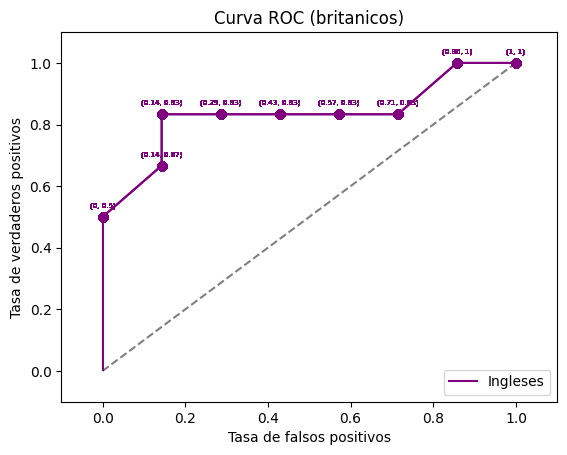

In [29]:
plot_roc_from_positive_rates(roc_positive_rates, "Curva ROC (britanicos)", "roc_curve_brit.png", annotate=True, font_size=5, label="Ingleses")

In [30]:
def get_single_prediction_dict(output_df : pd.Series, train_df, laplace_smoothing=False):
    prediction = get_single_prediction(output_df, train_df, laplace_smoothing)
    prediction = prediction[list(prediction.keys())[0]]
    prediction.pop('max')
    return {
        "N" : prediction["I"],
        "P" : prediction["E"]
    }

In [31]:
prediction_probabilities = dict()
predicted = dict()
for sample_idx, sample in train_df.drop("Nacionalidad", axis="columns").iterrows():
    predicted[sample_idx]                = get_single_prediction_label(sample, train_df)
    prediction_probabilities[sample_idx] = get_single_prediction_dict(sample, train_df)
prediction_probabilities

{0: {'N': 0.009615384615384616, 'P': 0.0},
 1: {'N': 0.009615384615384616, 'P': 0.04036779546983628},
 2: {'N': 0.019230769230769232, 'P': 0.02152949091724601},
 3: {'N': 0.019230769230769232, 'P': 0.028705987889661347},
 4: {'N': 0.019230769230769232, 'P': 0.0},
 5: {'N': 0.019230769230769232, 'P': 0.0},
 6: {'N': 0.019230769230769232, 'P': 0.04036779546983627},
 7: {'N': 0.019230769230769232, 'P': 0.02152949091724601},
 8: {'N': 0.009615384615384616, 'P': 0.053823727293115034},
 9: {'N': 0.019230769230769232, 'P': 0.07176496972415337},
 10: {'N': 0.019230769230769232, 'P': 0.05382372729311503},
 11: {'N': 0.009615384615384616, 'P': 0.04036779546983628},
 12: {'N': 0.009615384615384616, 'P': 0.01614711818793451}}

In [32]:
train_df_label_dict_p_or_f = dict()
for key in train_df_label_dict.keys():
    train_df_label_dict_p_or_f[key] = "N" if train_df_label_dict[key] == "I" \
                                 else "P"

In [33]:
roc_conf_mats_e = calculate_roc_confusion_matrices(prediction_probabilities, train_df_label_dict_p_or_f, np.arange(0, 1, 0.0001))
roc_conf_mats_e

[{'threshold': 0.0,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  6.0  0.0},
 {'threshold': 0.0001,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 {'threshold': 0.0002,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 {'threshold': 0.00030000000000000003,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 {'threshold': 0.0004,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 {'threshold': 0.0005,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 {'threshold': 0.0006000000000000001,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 {'threshold': 0.0007,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 {'threshold': 0.0008,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 {'threshold': 0.0009000000000000001,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 {'threshold': 0.001,
  'confusion_matrix':      P    N
  P  7.0  0.0
  N  3.0  3.0},
 

In [34]:
roc_positive_rates_e = calculate_roc_positive_rates(roc_conf_mats_e)
roc_positive_rates_e

[{'threshold': 0.0, 'TPR': 1.0, 'FPR': 1.0},
 {'threshold': 0.0001, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0002, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.00030000000000000003, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0004, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0005, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0006000000000000001, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0007, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0008, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0009000000000000001, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.001, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0011, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0012000000000000001, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0013000000000000002, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0014, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0015, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0016, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0017000000000000001, 'TPR': 1.0, 'FPR': 0.5},
 {'threshold': 0.0018000000000000002, 'TPR': 1.0,

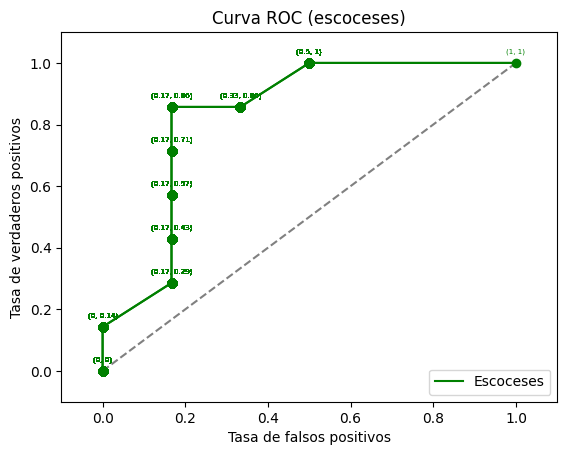

In [35]:
plot_roc_from_positive_rates(roc_positive_rates_e, "Curva ROC (escoceses)", "roc_curve_scotch.png", annotate=True, font_size=5, label="Escoceses", color="green")

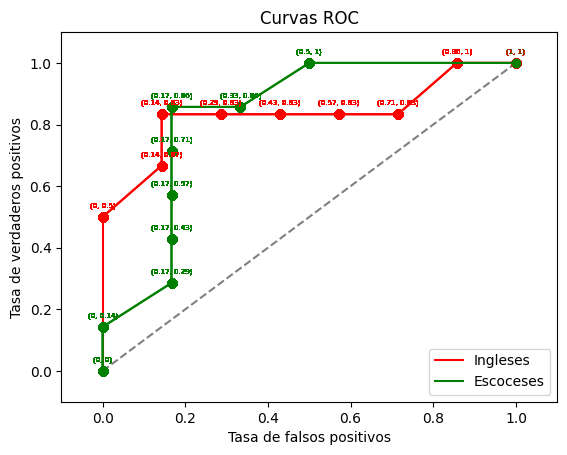

In [36]:
plot_multiple_roc_fromm_positive_rates([roc_positive_rates, roc_positive_rates_e], ["red", "green"], "Curvas ROC", "roc_curves.png", labels=["Ingleses", "Escoceses"], annotate=True)

In [37]:
from confusion_matrix import calculate_auc_from_positive_rates

In [38]:
calculate_auc_from_positive_rates(roc_positive_rates)

0.8333333333333333